In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.api as sm
import glob
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

In [2]:
#Chemin 
STUDY_PATH=os.path.join("/NAS","dumbo","protocoles","PSY_bvFTD")

In [3]:
#Lecture des deux fichiers Excel (varaiables et imagerie)
var=pd.read_excel(os.path.join(STUDY_PATH,'BDD_Imagerie_Etude_Neuropsy_Variables.xlsx'),index_col="Nom")
var=var.drop(columns=["DIAGNOSTIC"])
var=var.drop(columns=["Date_IRM_Proche_BNP"])
var=var.drop(columns=["DDN"])
prof = pd.read_excel(os.path.join(STUDY_PATH,'BDD_Imagerie_Etude_Neuropsy_ProfileJD.xlsx'),index_col="Nom")

df_concat = pd.concat([var,prof],axis=1)
#Afin de créer le fichier csv pour l'analyse PALM
df_concat[["Subject","DIAGNOSTIC","AGE","Education_Y","Gender_1M_0F"]].to_csv(os.path.join(STUDY_PATH,"groups.csv"),index=False)

#check CQ verif si l'age de ce patient est ok
df_concat.loc[df_concat["Subject"] == "PSY007"]["AGE"]

Nom
BOCOURT    59.0
Name: AGE, dtype: float64

In [4]:
df_concat[["Subject","DIAGNOSTIC","AGE","Education_Y","Gender_1M_0F","FER_total"]].to_csv(os.path.join(STUDY_PATH,"palm_regFER_total.csv"),index=False)

In [5]:
#Variables à prendre en compte
var4Corr=["miniSEA_total","FER_total","mFP_total","FCSRT_RL","FCSRT_TR","FCSRT_DTR","FER_CVE","FER_NCVE","mFP_MalInt","mFP_IDK","FCSRT_SemIntru","FCSRT_Rd"]
var4CorrNormMinMax = [x+'NormMinMax' for x in var4Corr]
var4CorrNormZScore = [x+'NormZScore' for x in var4Corr]
var4Cov=['AGE','Education_Y','Gender_1M_0F']
var4CovNormMinMax = [x+'NormMinMax' for x in var4Cov]
var4CovNormZScore = [x+'NormZScore' for x in var4Cov]
Var4Tar=['DIAGNOSTIC']

### Normalisation Min-Max pour les variables explicatives et les covariables

In [6]:
for col in var4Corr+var4Cov :
    # Calculer les valeurs min et max de la colonne
    min_value = df_concat[col].min()
    max_value = df_concat[col].max()
    # Appliquer la formule de normalisation min-max
    df_concat[col+'NormMinMax'] = (df_concat[col] - min_value) / (max_value - min_value)

### Normalisation Z-Score pour les variables explicatives et les covariables

In [7]:
for col in var4Corr+var4Cov :
    # Calculer les valeurs min et max de la colonne
    meanVal = df_concat[col].mean()
    stdVal = df_concat[col].std()
    # Appliquer la formule de normalisation min-max
    df_concat[col+'NormZScore'] = (df_concat[col] - meanVal) / stdVal

### Regression des covariables : Age, niveau d'éducation et genre

In [8]:
for col in var4CorrNormMinMax+var4CorrNormZScore :
    #print(col)
    tmp=df_concat[[col]+var4CovNormZScore].dropna()
    test=unconfound(tmp[[col]].values,tmp[var4CovNormZScore].values.take([2,0,1],axis=1),True)
    print(np.mean(df_concat[col]),np.std(df_concat[col]))
    for cpt,index in enumerate(df_concat.loc[~df_concat[col].isnull()].index):
        df_concat.loc[index,col]=test[cpt]
    #print(np.mean(df_concat[col]))

NameError: name 'unconfound' is not defined

In [ ]:
TPP=df_concat[df_concat["DIAGNOSTIC"]=="TPP"]
DFT=df_concat[df_concat["DIAGNOSTIC"]=="DFTc"]

### Radar plot sur les variables explicatives et les covariables

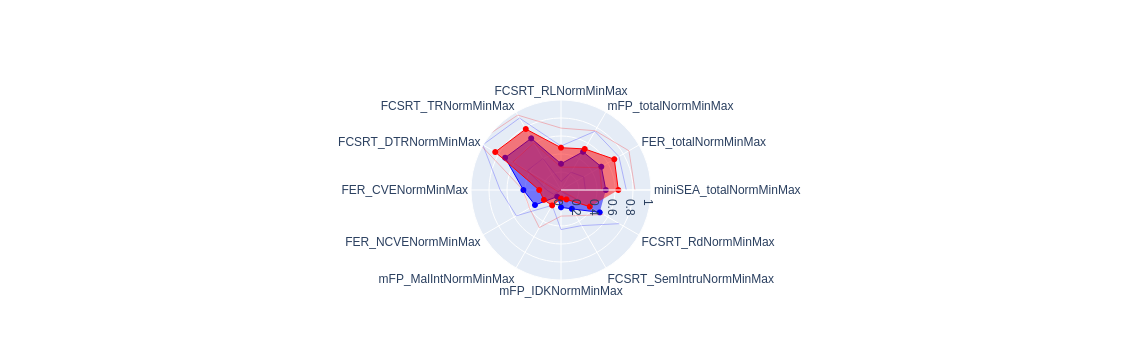

In [ ]:
fig = go.Figure()
moyDFT=DFT[var4CorrNormMinMax].mean()#df_concat.loc[DFT.index,var4CorrNormMinMax].mean() #df_concat.loc[DFT.iloc[:,0],var4CorrNormZScore].mean()
stdDFT=DFT[var4CorrNormMinMax].std()#df_concat.loc[DFT.index,var4CorrNormMinMax].std()
res1 = [x-y for x,y in zip(moyDFT,stdDFT)] 
res2 = [x+y for x,y in zip(moyDFT,stdDFT)] 

fig.add_trace(go.Scatterpolar(r=moyDFT,theta=var4CorrNormMinMax,fill='toself',mode='lines+markers',name='DFT',line=dict(width=1, color='blue')))
fig.add_trace(go.Scatterpolar(r=res1,theta=var4CorrNormMinMax,fill='none',mode='lines',showlegend=False,opacity=0.5,line=dict(width=0.5, color='blue')))
fig.add_trace(go.Scatterpolar(r=res2,theta=var4CorrNormMinMax,fill='none',mode='lines',showlegend=False,opacity=0.5,line=dict(width=0.5, color='blue')))

moyTPP=TPP[var4CorrNormMinMax].mean()
stdTPP=TPP[var4CorrNormMinMax].std()
res1 = [x-y for x,y in zip(moyTPP,stdTPP)] 
res2 = [x+y for x,y in zip(moyTPP,stdTPP)] 

fig.add_trace(go.Scatterpolar(r=moyTPP,theta=var4CorrNormMinMax,fill='toself',mode='lines+markers',name='TPP',line=dict(width=1, color='red')))
fig.add_trace(go.Scatterpolar(r=res1,theta=var4CorrNormMinMax,fill='none',mode='lines',showlegend=False,opacity=0.5,line=dict(width=0.5, color='red')))
fig.add_trace(go.Scatterpolar(r=res2,theta=var4CorrNormMinMax,fill='none',mode='lines',showlegend=False,opacity=0.5,line=dict(width=0.5, color='red')))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=False
)

fig.show()

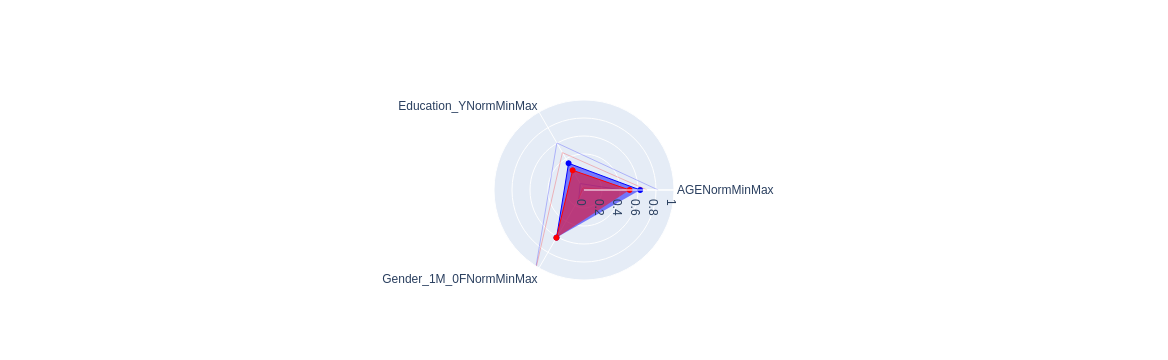

In [ ]:
fig = go.Figure()
moyDFT=DFT[var4CovNormMinMax].mean()#df_concat.loc[DFT.index,var4CorrNormMinMax].mean() #df_concat.loc[DFT.iloc[:,0],var4CorrNormZScore].mean()
stdDFT=DFT[var4CovNormMinMax].std()#df_concat.loc[DFT.index,var4CorrNormMinMax].std()
res1 = [x-y for x,y in zip(moyDFT,stdDFT)] 
res2 = [x+y for x,y in zip(moyDFT,stdDFT)] 

fig.add_trace(go.Scatterpolar(r=moyDFT,theta=var4CovNormMinMax,fill='toself',mode='lines+markers',name='DFT',line=dict(width=1, color='blue')))
fig.add_trace(go.Scatterpolar(r=res1,theta=var4CovNormMinMax,fill='none',mode='lines',showlegend=False,opacity=0.5,line=dict(width=0.5, color='blue')))
fig.add_trace(go.Scatterpolar(r=res2,theta=var4CovNormMinMax,fill='none',mode='lines',showlegend=False,opacity=0.5,line=dict(width=0.5, color='blue')))

moyTPP=TPP[var4CovNormMinMax].mean()
stdTPP=TPP[var4CovNormMinMax].std()
res1 = [x-y for x,y in zip(moyTPP,stdTPP)] 
res2 = [x+y for x,y in zip(moyTPP,stdTPP)] 

fig.add_trace(go.Scatterpolar(r=moyTPP,theta=var4CovNormMinMax,fill='toself',mode='lines+markers',name='TPP',line=dict(width=1, color='red')))
fig.add_trace(go.Scatterpolar(r=res1,theta=var4CovNormMinMax,fill='none',mode='lines',showlegend=False,opacity=0.5,line=dict(width=0.5, color='red')))
fig.add_trace(go.Scatterpolar(r=res2,theta=var4CovNormMinMax,fill='none',mode='lines',showlegend=False,opacity=0.5,line=dict(width=0.5, color='red')))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=False
)

fig.show()

### Table de contingence pour le genre

In [ ]:
# Créer un tableau de contingence
contingency_table = pd.crosstab(df_concat["DIAGNOSTIC"], df_concat["Gender_1M_0F"])
# Effectuer un test Chi-squared
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(contingency_table)
print(chi2_stat, p_val, dof, expected )

Gender_1M_0F   0   1
DIAGNOSTIC          
DFTc          23  36
TPP           12  19
0.0 1.0 1 [[22.94444444 36.05555556]
 [12.05555556 18.94444444]]


### Correction par FDR des tests de students (DFTc Vs; TPP)

In [ ]:
p_values = [ttest_ind(df_concat[df_concat["DIAGNOSTIC"]=="DFTc"][[col]].dropna().values, df_concat[df_concat["DIAGNOSTIC"]=="TPP"][[col]].dropna().values, equal_var=False)[1][0] for col in var4CorrNormZScore+var4CovNormZScore]
b_fdr,p_fdr=sm.stats.fdrcorrection(p_values,alpha=0.05,method='indep',is_sorted=False)
p_val_corr_tri = sorted(zip(p_values, [elt.replace("NormZScore","") for elt in (var4CorrNormZScore+var4CovNormZScore)]))

FER_total  :  0.0004
FCSRT_RL  :  0.0005
FER_CVE  :  0.0007
AGE  :  0.0088


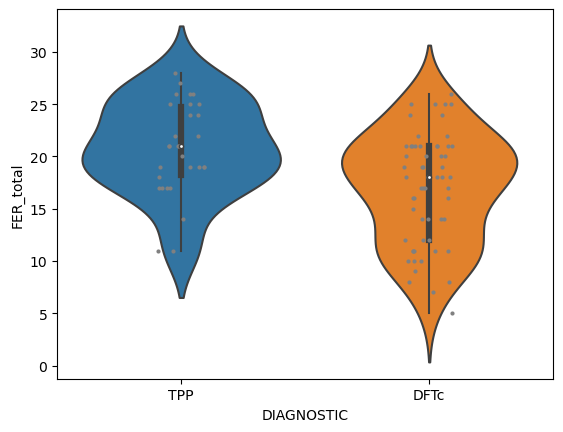

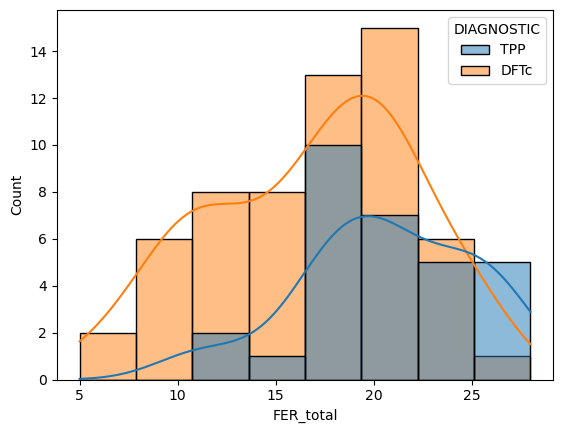

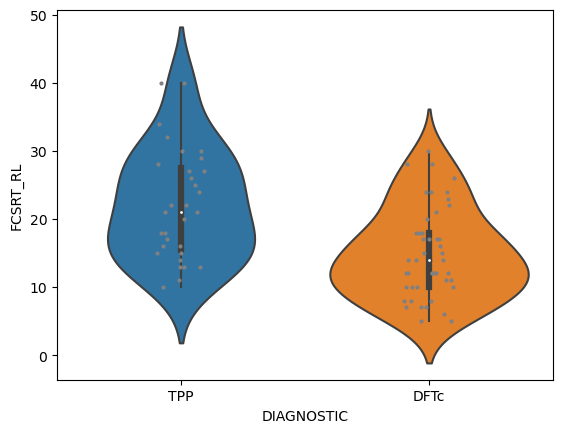

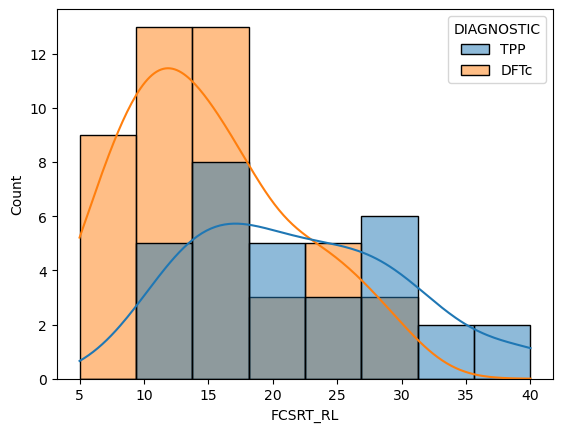

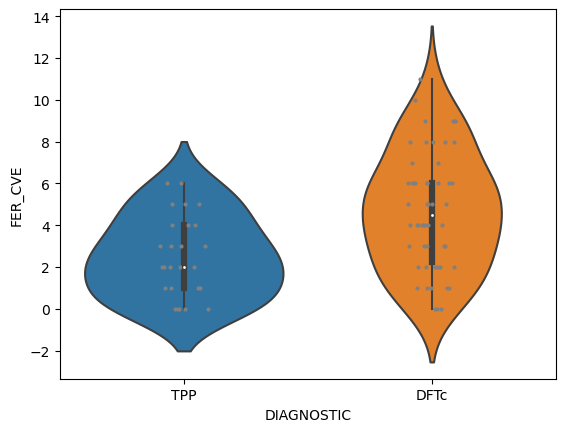

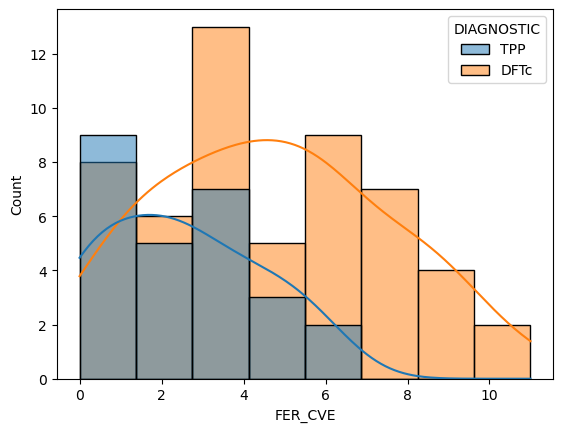

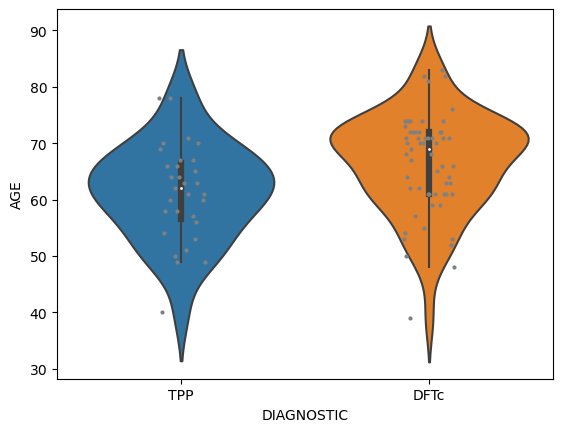

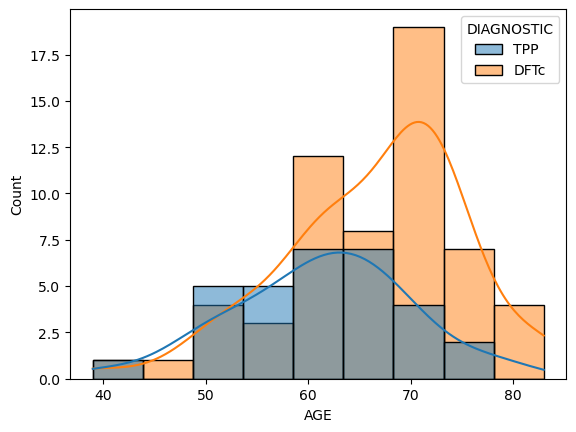

In [ ]:
for elt in p_val_corr_tri:    
    if elt[0]<0.01 :
        print(elt[1]," : ",round(elt[0],4))
        plt.figure()
        sns.stripplot(df_concat,y=elt[1],x="DIAGNOSTIC",size=3,color="gray")
        sns.violinplot(df_concat,y=elt[1],x="DIAGNOSTIC",split=True,alpha=0.5)
        p=plt.figure()
        sns.histplot(data=df_concat, x=elt[1],kde=True,hue="DIAGNOSTIC",bins='auto')

# Analyse de l'épaisseur corticale sans apriori (eq. cerveau entier)

In [ ]:
directories = glob.glob(os.path.join(STUDY_PATH,"HCP","*"))
dirHCP = set()
# Imprime la liste des répertoires
for directory in directories:
    dirHCP.add(directory.split("/")[6])

directories = glob.glob(os.path.join(STUDY_PATH,"data","bids","derivatives","f*","*"))
dirMICA = set()
# Imprime la liste des répertoires
for directory in directories:
    dirMICA.add(directory.split("/")[9])
    
print("présent que dans MICAPIPE : ",dirMICA-dirHCP)
print("présent que dans HCP : ",dirHCP-dirMICA)

présent que dans MICAPIPE :  {'fsLR-32k', 'sub-PSY040_ses-1', 'fsLR-5k', 'fsaverage5'}
présent que dans HCP :  {'sub-PSY056_ses-1', 'sub-PSY013_ses-1'}


## Cartes surfaciques d'épaisseur corticale par groupe 

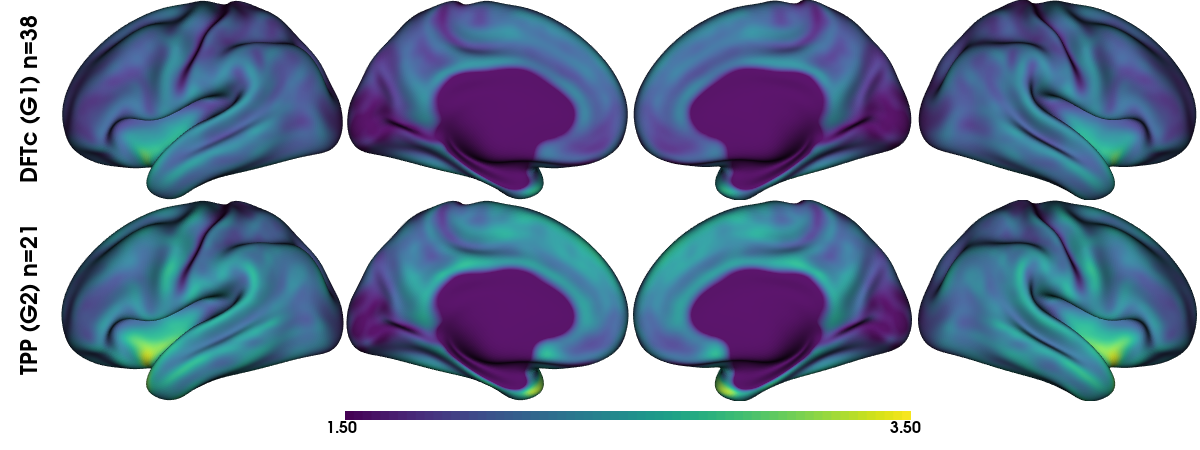

In [ ]:
###########
#Chargement des surfaces
###########
lh_surface_file="/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/freesurfer/fsLR-32k/surf/fsLR-32k.L.inflated.surf.gii"
#lh_surface_file="/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY066/ses-1/surf/sub-PSY066_ses-1_hemi-L_surf-fsnative_label-midthickness.surf.gii"
lh_surface_data = read_surface(lh_surface_file, itype='gii')

rh_surface_file="/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/freesurfer/fsLR-32k/surf/fsLR-32k.R.inflated.surf.gii"
#rh_surface_file="/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY066/ses-1/surf/sub-PSY066_ses-1_hemi-R_surf-fsnative_label-midthickness.surf.gii"
rh_surface_data = read_surface(rh_surface_file, itype='gii')

###########
#Chargement de l'épaisseur corticale moyenne pour le groupe G1 DFTc
###########
#lh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY088/ses-1/maps/sub-PSY088_ses-1_hemi-L_surf-fsLR-32k_label-thickness.func.gii'
lh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_GROUP/mean_G1_CT.L_sm10.func.gii'
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

#rh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY088/ses-1/maps/sub-PSY088_ses-1_hemi-R_surf-fsLR-32k_label-thickness.func.gii'
rh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_GROUP/mean_G1_CT.R_sm10.func.gii'
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volumeG1 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)

###########
#Chargement de l'épaisseur corticale moyenne pour le groupe G2 TPP
###########
lh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_GROUP/mean_G2_CT.L_sm10.func.gii'
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

rh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_GROUP/mean_G2_CT.R_sm10.func.gii'
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volumeG2 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)

tmp=nib.load('/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_GROUP/CT.L_sm10_G1.func.gii') 
n_G1=len(tmp.darrays)

tmp=nib.load('/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_GROUP/CT.L_sm10_G2.func.gii') 
n_G2=len(tmp.darrays)

labels = ['DFTc (G1) n='+str(n_G1),'TPP (G2) n='+str(n_G2)]

plot_hemispheres(lh_surface_data, rh_surface_data, array_name=[volumeG1,volumeG2],color_range=(1.5,3.5),size=(1200,450),label_text=labels,zoom=1.8,color_bar='bottom',share='both', embed_nb=True, interactive=True,nan_color=(0, 0, 0, 1), transparent_bg=False)

## Cartes statistiques des différences d'épaisseurs corticales corrigées par l'âge, le niveau d'éducation et le genre

In [ ]:
files = glob.glob(os.path.join(STUDY_PATH,"results","Palm_CT_*_PALM_with_cov_AGE_EDUC_SEX","results_CT_*_tfce_tstat_fwep_c*.gii"))
for file in files:
    lh_volume = [x.data for x in nib.load(file).darrays] 
    print(file,np.max(lh_volume[0]))

/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_5_PALM_with_cov_AGE_EDUC_SEX/results_CT_L_tfce_tstat_fwep_c1.gii 0.18144423
/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_5_PALM_with_cov_AGE_EDUC_SEX/results_CT_L_tfce_tstat_fwep_c2.gii 3.8383589
/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_5_PALM_with_cov_AGE_EDUC_SEX/results_CT_R_tfce_tstat_fwep_c1.gii 0.17933887
/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_5_PALM_with_cov_AGE_EDUC_SEX/results_CT_R_tfce_tstat_fwep_c2.gii 3.8630886
/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_PALM_with_cov_AGE_EDUC_SEX/results_CT_R_tfce_tstat_fwep_c1.gii 0.1325325
/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_PALM_with_cov_AGE_EDUC_SEX/results_CT_R_tfce_tstat_fwep_c2.gii 3.937539
/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_PALM_with_cov_AGE_EDUC_SEX/results_CT_L_tfce_tstat_fwep_c1.gii 0.13241467
/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_PALM_with_cov_AGE_EDUC_SEX/results_CT_L_tfce_tstat_fwep_c2.gii 3.9308941
/NAS/dumbo

In [ ]:
files = glob.glob(os.path.join(STUDY_PATH,"results","Palm_CT_10*_with_cov_AGE_EDUC_SEX_4*","results_CT_*_tfce_tstat_fwep.gii"))
for file in files:
    lh_volume = [x.data for x in nib.load(file).darrays] 
    print(file.split('/')[6:8],round(np.max(lh_volume[0]),2))

['Palm_CT_10_REG_FERTOT_with_cov_AGE_EDUC_SEX_4_ALL', 'results_CT_R_tfce_tstat_fwep.gii'] 1.13
['Palm_CT_10_REG_FERTOT_with_cov_AGE_EDUC_SEX_4_ALL', 'results_CT_L_tfce_tstat_fwep.gii'] 1.14
['Palm_CT_10_REG_FERTOT_with_cov_AGE_EDUC_SEX_4_DFTc', 'results_CT_R_tfce_tstat_fwep.gii'] 0.13
['Palm_CT_10_REG_FERTOT_with_cov_AGE_EDUC_SEX_4_DFTc', 'results_CT_L_tfce_tstat_fwep.gii'] 0.12
['Palm_CT_10_REG_FERTOT_with_cov_AGE_EDUC_SEX_4_TPP', 'results_CT_L_tfce_tstat_fwep.gii'] 0.76
['Palm_CT_10_REG_FERTOT_with_cov_AGE_EDUC_SEX_4_TPP', 'results_CT_R_tfce_tstat_fwep.gii'] 0.75


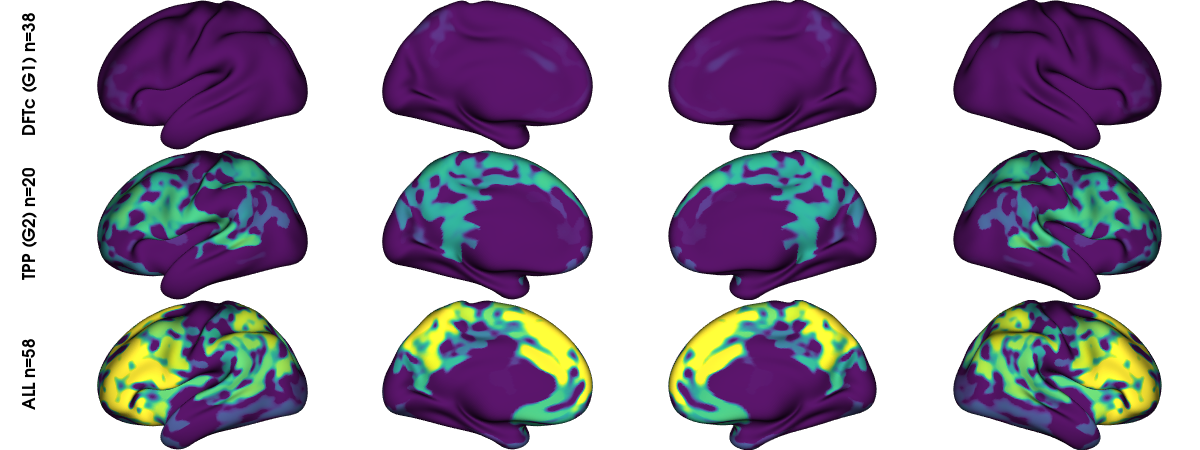

In [ ]:
###########
#Chargement des surfaces
###########
lh_surface_file="/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/freesurfer/fsLR-32k/surf/fsLR-32k.L.inflated.surf.gii"
#lh_surface_file="/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY066/ses-1/surf/sub-PSY066_ses-1_hemi-L_surf-fsnative_label-midthickness.surf.gii"
lh_surface_data = read_surface(lh_surface_file, itype='gii')

rh_surface_file="/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/freesurfer/fsLR-32k/surf/fsLR-32k.R.inflated.surf.gii"
#rh_surface_file="/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY066/ses-1/surf/sub-PSY066_ses-1_hemi-R_surf-fsnative_label-midthickness.surf.gii"
rh_surface_data = read_surface(rh_surface_file, itype='gii')

###########
#Chargement de la correlation CT/FERTot pour le groupe G1 DFTc
###########
#lh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY088/ses-1/maps/sub-PSY088_ses-1_hemi-L_surf-fsLR-32k_label-thickness.func.gii'
lh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_REG_FERTOT_with_cov_AGE_EDUC_SEX_4_DFTc/results_CT_L_tfce_tstat_fwep.gii'
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

#rh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY088/ses-1/maps/sub-PSY088_ses-1_hemi-R_surf-fsLR-32k_label-thickness.func.gii'
rh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_REG_FERTOT_with_cov_AGE_EDUC_SEX_4_DFTc/results_CT_R_tfce_tstat_fwep.gii'
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volumeG1 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)

###########
#Chargement de la correlation CT/FERTot pour le groupe G2 TPP
###########
lh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_REG_FERTOT_with_cov_AGE_EDUC_SEX_4_TPP/results_CT_L_tfce_tstat_fwep.gii'
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

rh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_REG_FERTOT_with_cov_AGE_EDUC_SEX_4_TPP/results_CT_R_tfce_tstat_fwep.gii'
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volumeG2 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)

###########
#Chargement de la correlation CT/FERTot pour tous TPP+DFTc
###########
lh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_REG_FERTOT_with_cov_AGE_EDUC_SEX_4_ALL/results_CT_L_tfce_tstat_fwep.gii'
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

rh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_REG_FERTOT_with_cov_AGE_EDUC_SEX_4_ALL/results_CT_R_tfce_tstat_fwep.gii'
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volumeG3 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)

tmp=nib.load('/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_REG_FERTOT_with_cov_AGE_EDUC_SEX_4_DFTc/CT.L_sm10.func.gii') 
n_G1=len(tmp.darrays)

tmp=nib.load('/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_REG_FERTOT_with_cov_AGE_EDUC_SEX_4_TPP/CT.L_sm10.func.gii') 
n_G2=len(tmp.darrays)

tmp=nib.load('/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_10_REG_FERTOT_with_cov_AGE_EDUC_SEX_4_ALL/CT.L_sm10.func.gii') 
n_G3=len(tmp.darrays)

labels = ['DFTc (G1) n='+str(n_G1),'TPP (G2) n='+str(n_G2),'ALL n='+str(n_G3)]

#Pour interagir avec la figure
#plot_hemispheres(lh_surface_data, rh_surface_data,array_name=[volumeG1,volumeG2,volumeG3],size=(1200,450),label_text=labels,zoom=1.8,nan_color=(0, 0, 0, 1),transparent_bg=False,share='both',interactive=True,color_range=(0,1))

plot_hemispheres(lh_surface_data, rh_surface_data,array_name=[volumeG1,volumeG2,volumeG3],size=(1200,450),label_text=labels,zoom=1.8,nan_color=(0, 0, 0, 1),transparent_bg=False, embed_nb=True,share='both',interactive=True,color_range=(0,1))

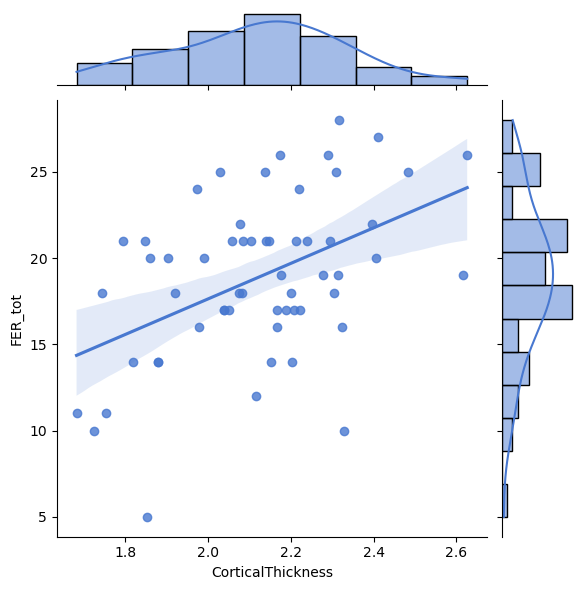

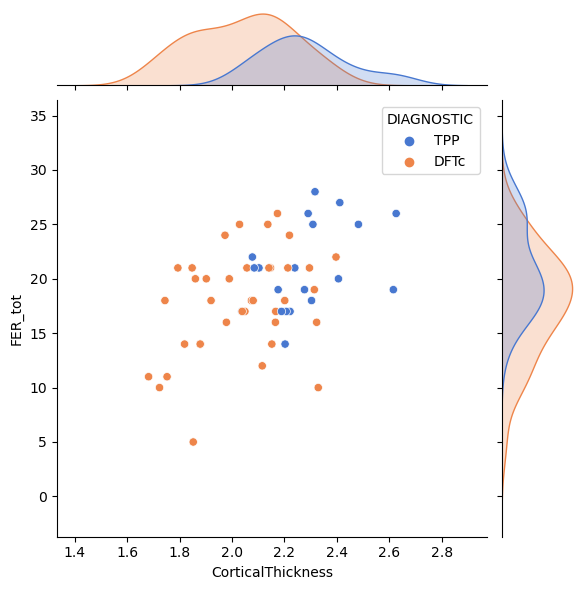

In [ ]:
lh_file= os.path.join(STUDY_PATH,"results","Palm_CT_10_REG_FERTOT_with_cov_AGE_EDUC_SEX_4_ALL","results_CT_L_tfce_tstat_fwep.gii")
lh_volume = [x.data for x in nib.load(lh_file).darrays] 
ind=[lh_volume[0]>1][0].reshape(32492)

df_tmp=pd.read_csv(os.path.join(STUDY_PATH,"palm_regFER_total.csv"))
valCT=[]
valFER=[]
group=[]
for elt in df_tmp.iterrows():
    path_file=os.path.join(STUDY_PATH,"data","bids","derivatives","micapipe_v0.2.0","sub-"+str(elt[1]["Subject"]),"ses-1","maps","sub-"+str(elt[1]["Subject"])+"_ses-1_hemi-L_surf-fsLR-32k_label-thickness.func.gii")    
    if os.path.exists(path_file):
        tmp=nib.load(path_file) 
        valCT.append(np.mean(tmp.darrays[0].data[ind]))
        valFER.append(elt[1]["FER_total"])
        group.append(elt[1]["DIAGNOSTIC"])
df = pd.DataFrame({'CorticalThickness': valCT, 'FER_tot': valFER,'DIAGNOSTIC':group})

sns.jointplot(df,y="FER_tot",x="CorticalThickness",kind="reg")
sns.jointplot(df,y="FER_tot",x="CorticalThickness",hue="DIAGNOSTIC")

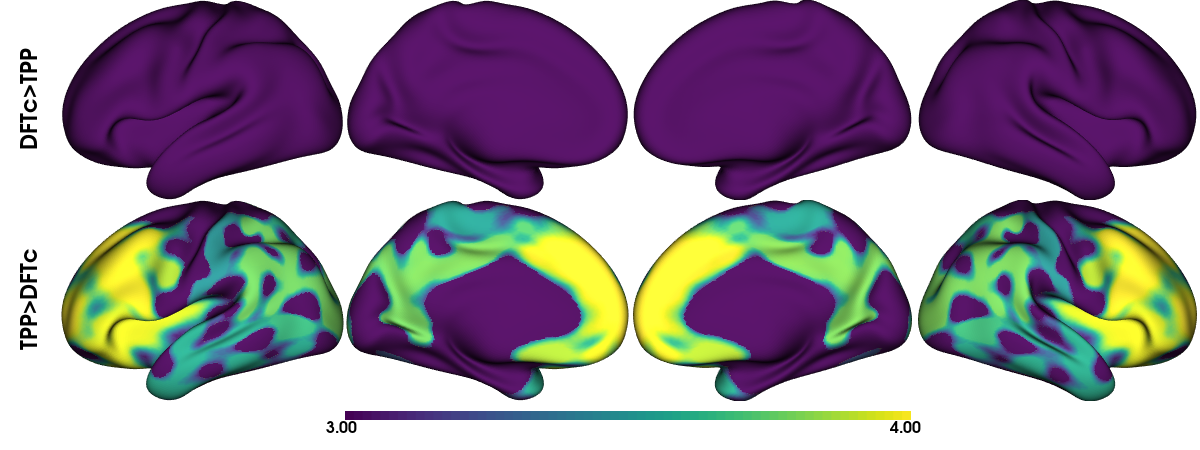

In [ ]:
lh_surface_file="/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/freesurfer/fsLR-32k/surf/fsLR-32k.L.inflated.surf.gii"
#lh_surface_file="/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY066/ses-1/surf/sub-PSY066_ses-1_hemi-L_surf-fsnative_label-midthickness.surf.gii"
lh_surface_data = read_surface(lh_surface_file, itype='gii')

rh_surface_file="/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/freesurfer/fsLR-32k/surf/fsLR-32k.R.inflated.surf.gii"
#rh_surface_file="/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY066/ses-1/surf/sub-PSY066_ses-1_hemi-R_surf-fsnative_label-midthickness.surf.gii"
rh_surface_data = read_surface(rh_surface_file, itype='gii')

lh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_20_PALM_with_cov_AGE_EDUC_SEX/results_CT_L_tfce_tstat_fwep_c1.gii'
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

rh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_20_PALM_with_cov_AGE_EDUC_SEX/results_CT_R_tfce_tstat_fwep_c1.gii'
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volume_c1 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)
volume_c1[volume_c1<3]=0

lh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_20_PALM_with_cov_AGE_EDUC_SEX/results_CT_L_tfce_tstat_fwep_c2.gii'
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

rh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/results/Palm_CT_20_PALM_with_cov_AGE_EDUC_SEX/results_CT_R_tfce_tstat_fwep_c2.gii'
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volume_c2 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)
volume_c2[volume_c2<3]=0

labels = ['DFTc>TPP','TPP>DFTc']
#plot_hemispheres(lh_surface_data, rh_surface_data, array_name=array_name=[volumeG1,volumeG2])
plot_hemispheres(lh_surface_data, rh_surface_data, array_name=[volume_c1,volume_c2],size=(1200, 450),color_range=(3,4),label_text=labels,zoom=1.8,color_bar='bottom',share='both',embed_nb=True,interactive=True,nan_color=(0, 0, 0, 1),transparent_bg=False)

# Analyses des sillons par BRAINVISA

In [ ]:
files = glob.glob(os.path.join(STUDY_PATH,"csv_sulcus","sub-PSY0*_morphometry.csv"))
clinical_data=pd.read_csv(os.path.join(STUDY_PATH,"groups.csv"),sep=',',index_col='Subject')

df4col=pd.read_csv(os.path.join(STUDY_PATH,"csv_sulcus","sub-PSY088_ses-1_acq-2013DT1TFE++3D_T1w_default_session_auto_sulcal_morphometry.csv"),sep=';')
colonnes=['subj','group','age','sexe']
for sillon in df4col['sulcus']:
    for col in df4col.columns[3:]:
        colonnes.append(sillon+"_"+col)

df_test = pd.concat([clinical_data, pd.DataFrame(columns=colonnes[2:])], axis=1)
df = pd.DataFrame(columns=colonnes)

for cpt,file in enumerate(files) :
    df_tmp=pd.read_csv(file,sep=';')        
    subj=file.split('/')[6][4:10]
    #print(cpt,subj)
    diag=clinical_data.loc[subj].DIAGNOSTIC 
    age=clinical_data.loc[subj].AGE 
    sex=clinical_data.loc[subj].Gender_1M_0F 
    maliste=[subj,diag,age,sex]
    #print(cpt,maliste)
    df.loc[cpt]=maliste+list(df_tmp.iloc[:,3:].values.flatten())

### Liste de sillons et des paramètres  étudiés 

In [ ]:
sulcus_list=['INSULA','S.F.median.','S.F.inf.ant.','S.F.sup.','S.F.marginal.','S.F.inter.','S.F.int.']
bv_param_list=['opening']
col_list=[]
for sul in sulcus_list :
    for lat in ['left','right']:
        for par in bv_param_list :
            col_list.append(sul+'_'+lat+'_'+par)
print(col_list)

['INSULA_left_opening', 'INSULA_right_opening', 'S.F.median._left_opening', 'S.F.median._right_opening', 'S.F.inf.ant._left_opening', 'S.F.inf.ant._right_opening', 'S.F.sup._left_opening', 'S.F.sup._right_opening', 'S.F.marginal._left_opening', 'S.F.marginal._right_opening', 'S.F.inter._left_opening', 'S.F.inter._right_opening', 'S.F.int._left_opening', 'S.F.int._right_opening']


### Lecture du fichier la correspondance label  et acronyme de Brainvisa

In [ ]:
lut_names=pd.read_csv(os.path.join(STUDY_PATH,"anat_landmark_atlas.csv"),sep=',')  

Pour récuper un label à prtir d'un acronyme

In [ ]:
valeur_acronym = 'F.C.L.a._left'
colonne_label = lut_names.loc[lut_names['brainvisa_acronym'] == valeur_acronym, 'label']
colonne_label[0]

'Left anterior lateral fissure'

Ou l'inverse un acronyme à partir d'un label

In [ ]:
valeur_label = 'Left anterior lateral fissure'
colonne_acronym = lut_names.loc[lut_names['label'] == valeur_label, 'brainvisa_acronym']
colonne_acronym[0]

'F.C.L.a._left'

In [ ]:
lut_names.loc[lut_names['label'].str.contains("frontal"), ['brainvisa_acronym','label']]

,brainvisa_acronym,label
48,S.F.inf._left,Left inferior frontal sulcus
49,S.F.inf._right,Right inferior frontal sulcus
50,S.F.inf.ant._left,Left anterior inferior frontal sulcus
51,S.F.inf.ant._right,Right anterior inferior frontal sulcus
52,S.F.int._left,Left internal frontal sulcus
53,S.F.int._right,Right internal frontal sulcus
54,S.F.inter._left,Left intermediate frontal sulcus
55,S.F.inter._right,Right intermediate frontal sulcus
56,S.F.marginal._left,Left marginal frontal sulcus
57,S.F.marginal._right,Right marginal frontal sulcus


In [ ]:
#colonnes_fil = df.filter(regex='GM_thickness$', axis=1)
#colonnes_fil = df.filter(regex='opening$', axis=1)
#colonnes_fil = df.filter(regex='_', axis=1)
colonnes_fil = df.filter(regex='^(F.C.M.|F.I.P.)', axis=1)
colonnes_fil = df[col_list]
groupe_DFTc = df[df['group'] == 'DFTc'].loc[:][2:]
groupe_TPP = df[df['group'] == 'TPP'].loc[:][2:]

### calcul des ttests pour les sillons/parametres definis ci-dessus

In [ ]:
p_values = [ttest_ind(df[df['group'] == 'DFTc'].loc[:][col].dropna(), df[df['group'] == 'TPP'].loc[:][col].dropna(), equal_var=False)[1] for col in colonnes_fil.columns]
b_fdr,p_fdr=sm.stats.fdrcorrection(p_values,alpha=0.05,method='indep',is_sorted=False)
p_val_corr_tri = sorted(zip(p_values, [elt.replace("NormZScore","") for elt in colonnes_fil.columns]))

In [ ]:
df=df[::-1]

Right intermediate frontal sulcus , p_FDR_value =  0.0
Left intermediate frontal sulcus , p_FDR_value =  0.0
Left internal frontal sulcus , p_FDR_value =  0.0001
              attention 1 exclus à +/- 3 IQR
Right anterior inferior frontal sulcus , p_FDR_value =  0.0003
              attention 1 exclus à +/- 3 IQR
Right superior frontal sulcus , p_FDR_value =  0.0009


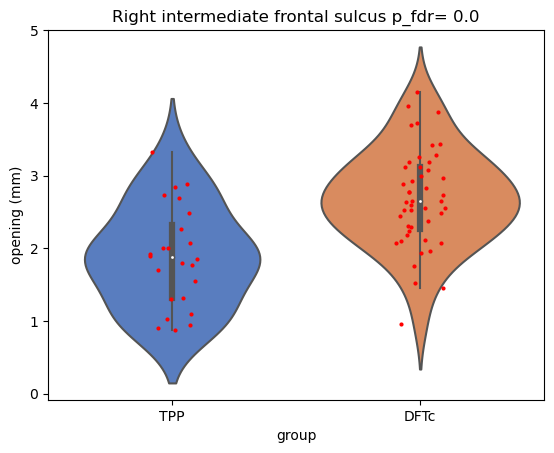

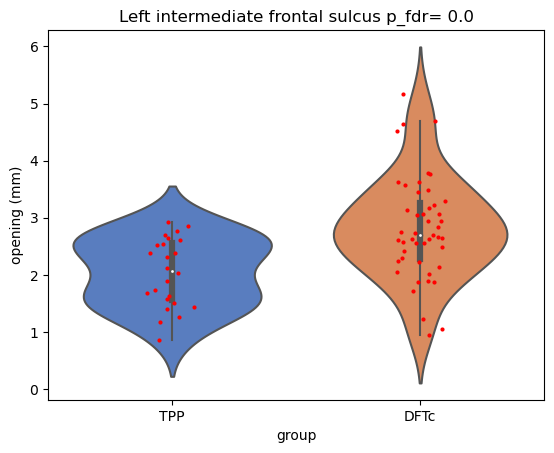

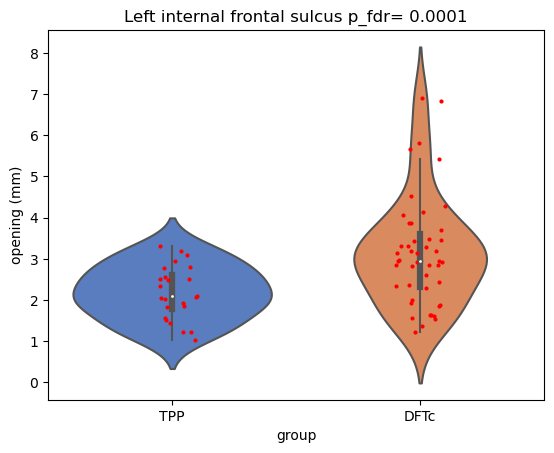

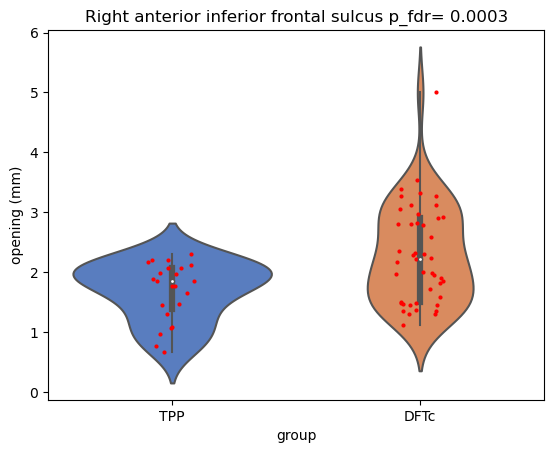

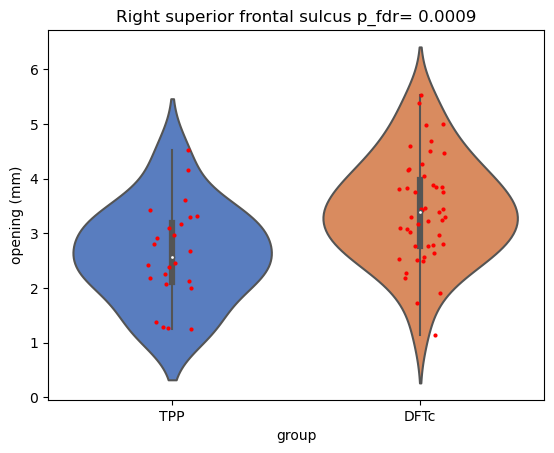

In [ ]:
for elt in p_val_corr_tri :
    if (elt[0]<0.001):
        colonne_label = lut_names.loc[lut_names['brainvisa_acronym'] == elt[1].split('_')[0]+"_"+elt[1].split('_')[1], 'label']
        print(colonne_label.values[0],", p_FDR_value = ",round(elt[0],4))
        
        #CQ/QC
        median = df[elt[1]].median()
        q1 = df[elt[1]].quantile(0.25)
        q3 = df[elt[1]].quantile(0.75)
        iqr = q3 - q1
        borne_inf = median - 3 * iqr
        borne_sup = median + 3 * iqr
        #print(np.min(df[elt[1]]),np.max(df[elt[1]]),borne_inf,borne_sup)
        df_filtre = df[(df[elt[1]] <= borne_inf) | (df[elt[1]] >= borne_sup)]
        if (len(df_filtre.index) > 0):
            print("              attention "+str(len(df_filtre.index)) + " exclus à +/- 3 IQR")
        
        plt.figure()
        sns.stripplot(df,y=elt[1],x="group",size=3,color="red")
        ax=sns.violinplot(df,y=elt[1],x="group",split=True,palette="muted")
        plt.title(colonne_label.values[0]+" p_fdr= "+str(np.round(elt[0],4)))
        plt.ylabel(elt[1].split('_')[2]+" (mm)")       

In [ ]:
lh_file= '/NAS/deathrow/protocoles/predistim/results/Palm_4_NC_F_CT_10/L_area.func.gii'
lh_volume = [x.data for x in nib.load(lh_file).darrays] 
print(len(lh_volume[0]))
lh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY049/ses-1/surf/sub-PSY049_ses-1_hemi-L_surf-fsnative_label-midthickness.surf.gii'
lh_volume = [x.data for x in nib.load(lh_file).darrays] 
print(len(lh_volume[0]))
lh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/freesurfer/fsLR-32k/surf/fsLR-32k.L.midthickness.surf.gii'
lh_volume = [x.data for x in nib.load(lh_file).darrays] 
print(len(lh_volume[0]))

32492
376939
32492


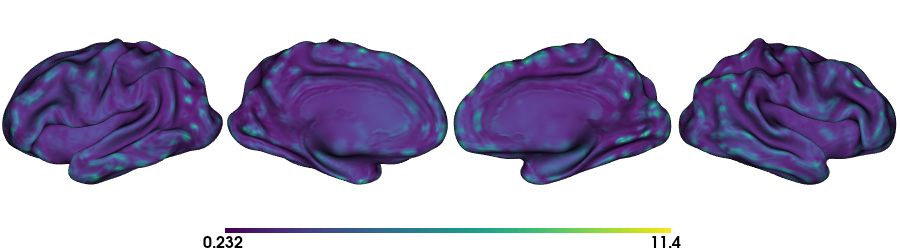

In [ ]:
lh_surface_file="/NAS/dumbo/protocoles/PSY_bvFTD/HCP/sub-PSY088_ses-1/T1w/fsaverage_LR32k/sub-PSY088_ses-1.L.inflated.32k_fs_LR.surf.gii"
lh_surface_data = read_surface(lh_surface_file, itype='gii')

rh_surface_file="/NAS/dumbo/protocoles/PSY_bvFTD/HCP/sub-PSY088_ses-1/T1w/fsaverage_LR32k/sub-PSY088_ses-1.R.inflated.32k_fs_LR.surf.gii"
rh_surface_data = read_surface(rh_surface_file, itype='gii')

lh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/HCP/sub-PSY088_ses-1/T1w/fsaverage_LR32k/sub-PSY088_ses-1.L.midthickness_va.32k_fs_LR.shape.gii'
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

rh_file= '/NAS/dumbo/protocoles/PSY_bvFTD/HCP/sub-PSY088_ses-1/T1w/fsaverage_LR32k/sub-PSY088_ses-1.R.midthickness_va.32k_fs_LR.shape.gii'
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volume = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)
plot_hemispheres(lh_surface_data, rh_surface_data, array_name=volume.T, size=(900, 250), zoom=1.25,color_bar='bottom',share='both', embed_nb=True, interactive=True,nan_color=(0, 0, 0, 1), transparent_bg=False)

AGENorm 0.0561 0.3298 0.0022
AGENorm -0.0 0.0 0.0


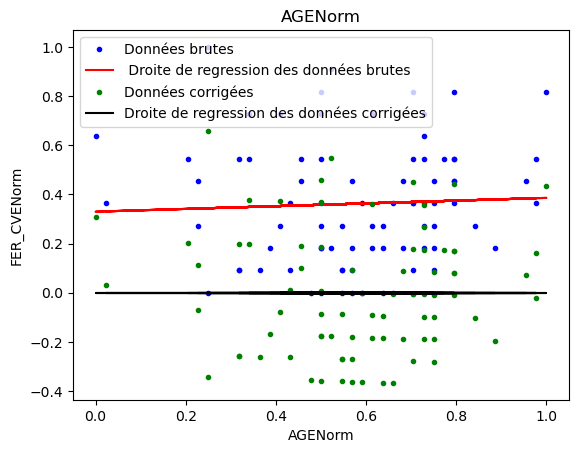

Education_YNorm 0.1125 0.3259 0.0139
Education_YNorm -0.0 0.0 0.0


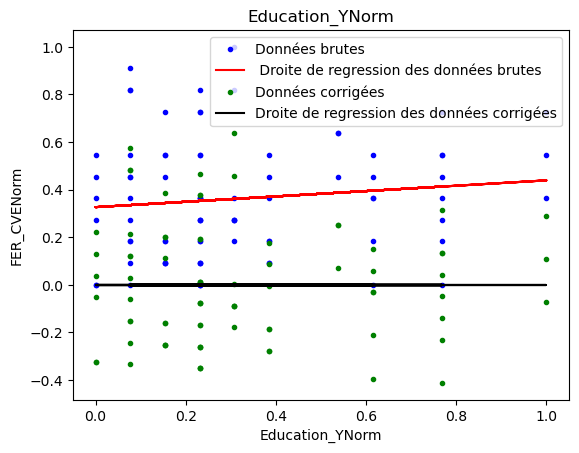

In [ ]:
for target in ["FER_CVENorm"]:#Var4Tar :
    for maCov in var4CovNorm[:2]:
        tmp=df_concat[[target,maCov]].dropna()
        y0=list(tmp[target])
        x0=list(tmp[maCov])
        y_actual=np.array(y0)
        x=np.array(x0)
        (a, b, r, val1, val2)= stats.linregress(x, y_actual)  # retourne les paramètres de la droite de regression
        A=round(a,4)
        B=round(b,4)
        R=round(r**2,4)
        print(maCov,A,B,R)                    # a=coéfficient directeur  b=ordonnée à l'origine  r**2= coéfficient de regression linéaire 
        plt.plot(x, y_actual, "b.", label="Données brutes") # les coordonnées (x, y) representés par des points
        y_predict=a*x+b                       # équation de la droite de regression
        plt.plot(x, y_predict, "-r",label=" Droite de regression des données brutes ")  # tracé de la droite de regression
        y_corrected=y_actual-y_predict
        plt.plot(x, y_corrected, "g.",label="Données corrigées")  # tracé de la droite résiduelle
        (a1, b1, r1, valeur1, valeur2)=stats.linregress(x, y_corrected)   # retourne les paramètres de la droite de regression pour les données corrigées
        A1=round(a1,4)
        B1=round(b1,4)
        R1=round(r1**2,4)
        print(maCov,A1,B1,R1)
        y_corrected_regress=a1*x+b1
        plt.plot(x, y_corrected_regress, "-k", label="Droite de regression des données corrigées")
        plt.xlabel(maCov) # nom de l'axe des abcisses
        plt.ylabel(target) # nom de l'axe des ordonnées 
        plt.legend() # creer la legende
        plt.title(maCov) # inserer le titre du graphique
        plt.show()  # afficher les courbes

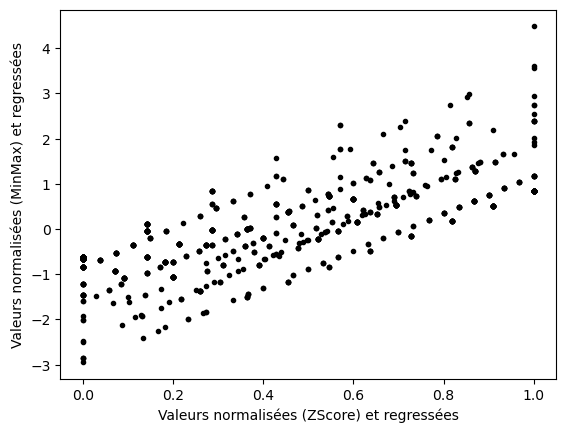

In [ ]:
for col1,col2 in zip(var4CorrNormMinMax,var4CorrNormZscore) :
    #plt.figure()
    plt.plot(df_concat[[col1]].values, df_concat[[col2]].values, ".k")
    plt.ylabel("Valeurs normalisées (MinMax) et regressées");plt.xlabel("Valeurs normalisées (ZScore) et regressées")

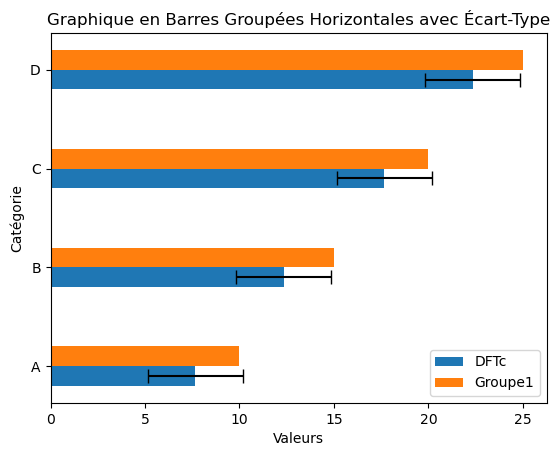

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Créer un DataFrame d'exemple
data = {
    'Categorie': ['A', 'B', 'C', 'D'],
    'Groupe1': [10, 15, 20, 25],
    'Groupe2': [8, 12, 18, 22],
    'Groupe3': [5, 10, 15, 20]
}

df1 = pd.DataFrame(data)

data = {
    'Groupe1': [10, 15, 20, 25],
    'Groupe2': [8, 12, 18, 22],
    'Groupe3': [5, 10, 15, 20]
}

df = pd.DataFrame(data)

# Calculer les moyennes et les écart-types
moyennes = df.mean(axis=1)
ecart_types = df.std(axis=1)

# Définir les positions des barres
positions = range(len(df1['Categorie']))

# Créer un graphique en barres groupées avec barres d'erreur horizontales
plt.barh(positions, moyennes, xerr=ecart_types, capsize=5, height=0.2, label='DFTc')
#plt.barh([pos + 0.2 for pos in positions], moyennes, xerr=ecart_types, capsize=5, height=0.2, label='Psp')


plt.barh([pos + 0.2 for pos in positions], df['Groupe1'], height=0.2, label='Groupe1')
#plt.barh([pos + 0.4 for pos in positions], df['Groupe2'], height=0.2, label='Groupe2')
#plt.barh([pos + 0.6 for pos in positions], df['Groupe3'], height=0.2, label='Groupe3')

# Ajouter des étiquettes
plt.ylabel('Catégorie')
plt.xlabel('Valeurs')
plt.title('Graphique en Barres Groupées Horizontales avec Écart-Type')
plt.yticks([pos + 0.1 for pos in positions], df1['Categorie'])
plt.legend()

# Afficher le graphique
plt.show()
